In [1]:
%matplotlib notebook

In [2]:
import calour as ca
import numpy as np
import pandas as pd
from calour.training import plot_roc
import matplotlib.pyplot as plt
ca.set_log_level(40)

These data are freely accessible on **QIITA (qiita.ucsd.edu) under the study ID 11829**. First, we will load the table with relative abundance of 16S tag sequences (normalized to 100) in Ldlr and ApoE KO along with metadata about all samples in the study using calour (http://biocore.github.io/calour/). 
We are interested in looking at fecal metabolome in this study, so we will filter out all other sample types. Lastly, we just include samples from mice that were fed high-fat diet (HFD) as HFD promoted atherosclerosis in our animal models; this is the phenotype of interest. 

**Description of metadata columns that we use for this analysis**
1. body_habitat : type of sample (fecal, plasma, oral etc.)
2. diet : 'HFD' (High-fat diet) or 'Regular chow' given to mice
3. exposure_type : 'Air' or 'IHH' (intermittent hypoxia and hypercapnia) exposure
4. mouse_number : denotes unique mouse ID for each mouse in the study
5. genotype : 'ApoE KO' (ApoE knockout animals) or 'Ldlr knockout' 
6. age : age of mice in weeks (the study starts at 10 weeks of age)

In [3]:
exp = ca.read_amplicon('../data/microbiome/combined_apoe_ldlr_norare_2k/feature-table.biom', 
                       '../data/combined_sample_metadata_HFD.txt', 
                       feature_metadata_file = '../data/microbiome/taxonomy/taxonomy.tsv',
                       normalize=100, min_reads=0)

In [4]:
apoe_all = ca.read_amplicon('../data/microbiome/apoe-batches-featuretable-2k/feature-table.biom', 
                         '../data/microbiome/apoe-batches-metadata.txt', 
                         normalize=100, min_reads=0)

# remove apoe samples from 10 week IHC batch. Only keep the 10 week IH and IC batch
apoe2 = apoe_all.filter_by_metadata(field='title', select=['10 week IH and IC'])


In [5]:
# join all batches
combatches = exp.join_experiments(apoe2)

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/calour/manipulation.py:242: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  smd = pd.concat([smd1, smd2], join='outer')


In [6]:
def plot_roc_mod(result, classes=None, title='ROC', cv=True, cmap=None,
                 cmodel = 'darkviolet', ax=None, 
                 test_name='across model', cv_name='within model'):
    
    '''this function plots ROC curves for within model cross validation 
    and across model prediction'''
    
    from matplotlib import pyplot as plt
    import itertools
    from sklearn.metrics import roc_curve, auc
    from matplotlib import pyplot as plt
    from scipy import interp, stats
    from logging import getLogger
    logger = getLogger(__name__)
    
    if cmap is None:
        cmap = plt.cm.Dark2
    if ax is None:
        fig, ax = plt.subplots()

    ax.set_aspect('equal')
    ax.plot([0, 1], [0, 1], linestyle='-', lw=1, color='black', label='Luck', alpha=.5)

    if classes is None:
        classes = np.unique(result['Y_TRUE'].values)
        classes.sort()

    col = dict(zip(classes, itertools.cycle(cmap.colors)))

    mean_fpr = np.linspace(0, 1, 100)
    for cls in classes:
        tprs = []
        aucs = []
        if cv is True:
            for grp, df in result.groupby('CV'):
                if grp == -1:
                    y_true = df['Y_TRUE'].values == cls
                    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, df[cls])
                    roc_auc = auc(false_positive_rate, true_positive_rate)

                    ax.plot(false_positive_rate,true_positive_rate, color=cmodel, 
                         label = '{0} ({1:.2f})'.format(test_name, roc_auc), linewidth=2)
                    continue
                else:
                    y_true = df['Y_TRUE'].values == cls
                    fpr, tpr, thresholds = roc_curve(y_true.astype(int), df[cls])
                    if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                        logger.warning(
                            'The cross validation fold %r is skipped because the true positive rate or '
                            'false positive rate computation failed. This is likely because you '
                            'have either no true positive or no negative samples in this '
                            'cross validation for the class %r' % (grp, cls))
                        continue
                    mean_tpr = interp(mean_fpr, fpr, tpr)
                    tprs.append(mean_tpr)
                    tprs[-1][0] = 0.0
                    roc_auc = auc(mean_fpr, mean_tpr)
                    aucs.append(roc_auc)

            mean_tpr = np.mean(tprs, axis=0)
            mean_tpr[-1] = 1.0
            mean_auc = np.mean(aucs)
            std_auc = np.std(aucs)
            ax.plot(mean_fpr, mean_tpr, color=col[cls],
                    label = '{0} ({1:.2f})'.format(cv_name, roc_auc),
                    lw=2, alpha=.8)

            std_tpr = np.std(tprs, axis=0)
            tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
            tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
            ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=col[cls], alpha=.5)

        else:
            y_true = result['Y_TRUE'].values == cls
            fpr, tpr, thresholds = roc_curve(y_true.astype(int), result[cls])
            if np.isnan(fpr[-1]) or np.isnan(tpr[-1]):
                logger.warning(
                    'The class %r is skipped because the true positive rate or '
                    'false positive rate computation failed. This is likely because you '
                    'have either no true positive or no negative samples for this class' % cls)
            roc_auc = auc(fpr, tpr)
            # prepend zero because, if not, the curve may start in the middle of the plot.
            ax.plot(np.insert(fpr, 0, 0), np.insert(tpr, 0, 0), label='{0} ({1:.2f})'.format(cls, roc_auc), lw=2)

    ax.set_xlim(-0.05, 1.05)
    ax.set_ylim(-0.05, 1.05)
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(title)
    ax.legend(loc="lower right")

    return ax

In [7]:
# number of samples in each batch
combatches.sample_metadata.title.value_counts()

10 week IH and IC    813
10 week IHC          460
OSA                  182
Name: title, dtype: int64

Below, we perform abundance-based filtering of features to retain only high-quality reliable features that are present above a certain threshold (cutoff) in at least a certain fraction (fraction) of samples within each animal model. 
Here, we use an abundance threshold of 10E-6 and we want the feature to be present in atleast 1% of the samples in each animal model. We also filter out baseline samples (age = 10 & 10.5 weeks) as HFD was not yet introduced at these timepoints.

In [8]:
# filtering features if the abundance is less than 'cutoff' in 'fraction' of samples in either 'genotype'
combatches2 = combatches.filter_prevalence(field='genotype', cutoff=0.000001, 
                                           fraction=0.01).filter_samples('age', [10, 10.5], 
                                                                          negate=True)
combatches2


AmpliconExperiment ("join feature-table.biom & feature-table.biom") with 1395 samples, 436 features

In [9]:
# subset ApoE KO samples from batch 1
apoe1 = combatches2.filter_samples('genotype', 
                                   'ApoE KO').filter_samples('title', '10 week IHC')
apoe1.sample_metadata.exposure_type.value_counts()

Air    211
IHH    201
Name: exposure_type, dtype: int64

In [10]:
# subset ApoE KO samples from batch 2
apoe2 = combatches2.filter_samples('genotype', 
                                   'ApoE KO').filter_samples('title', '10 week IH and IC')
apoe2.sample_metadata.exposure_type.value_counts()

IC     332
IH     330
Air    151
Name: exposure_type, dtype: int64

In [11]:
# subset Ldlr KO samples
ldlr = combatches2.filter_samples('genotype', 'LDLR knockout')
ldlr.sample_metadata.exposure_type.value_counts()

Air    85
IHH    85
Name: exposure_type, dtype: int64

## Classification using Random Forest (RF)

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score
from calour import training

### Train on ApoE KO batch 1 & test on ApoE KO batch 2 (negative control)

#### Train on ApoE KO batch 1 (Air vs IHH) 

Below, we make a Random Forest (RF) model using microbiome data from ApoE KO animals. We use 5-fold cross-validation (CV) and ensure that samples belonging to the same mouse (denoted by 'mouse_number') are either in training or testing set for each train/test split. We used GroupKfold (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) for this.

In [13]:
apoe1.sample_metadata.exposure_type.value_counts()

Air    211
IHH    201
Name: exposure_type, dtype: int64

In [14]:
# prepare training data
X_train = apoe1.data

# label encoder
y_train = []
for idx in apoe1.sample_metadata.index:
    if apoe1.sample_metadata.loc[idx, 'exposure_type'] == 'IHH':
        y_train.append(1)
    else:
        y_train.append(0)

In [15]:
apoe1.sample_metadata.exposure_type = y_train

In [16]:
it_apoe = apoe1.classify('exposure_type',
                          RandomForestClassifier(n_estimators=500),
                          GroupKFold(5).split(
                          X_train, y_train, 
                          apoe1.sample_metadata['mouse_number']))

In [17]:
# predictions for each CV fold
res_apoe = next(it_apoe)
res_apoe.head()

,0,1,Y_TRUE,SAMPLE,CV
0,0.212,0.788,1,11548.A19.104.3,0
1,0.948,0.052,0,11548.A21.112.11,0
2,0.914,0.086,0,11548.A21.112.8,0
3,0.962,0.038,0,11548.A22.113.17,0
4,0.074,0.926,1,11548.A20.105.17,0


<IPython.core.display.Javascript object>


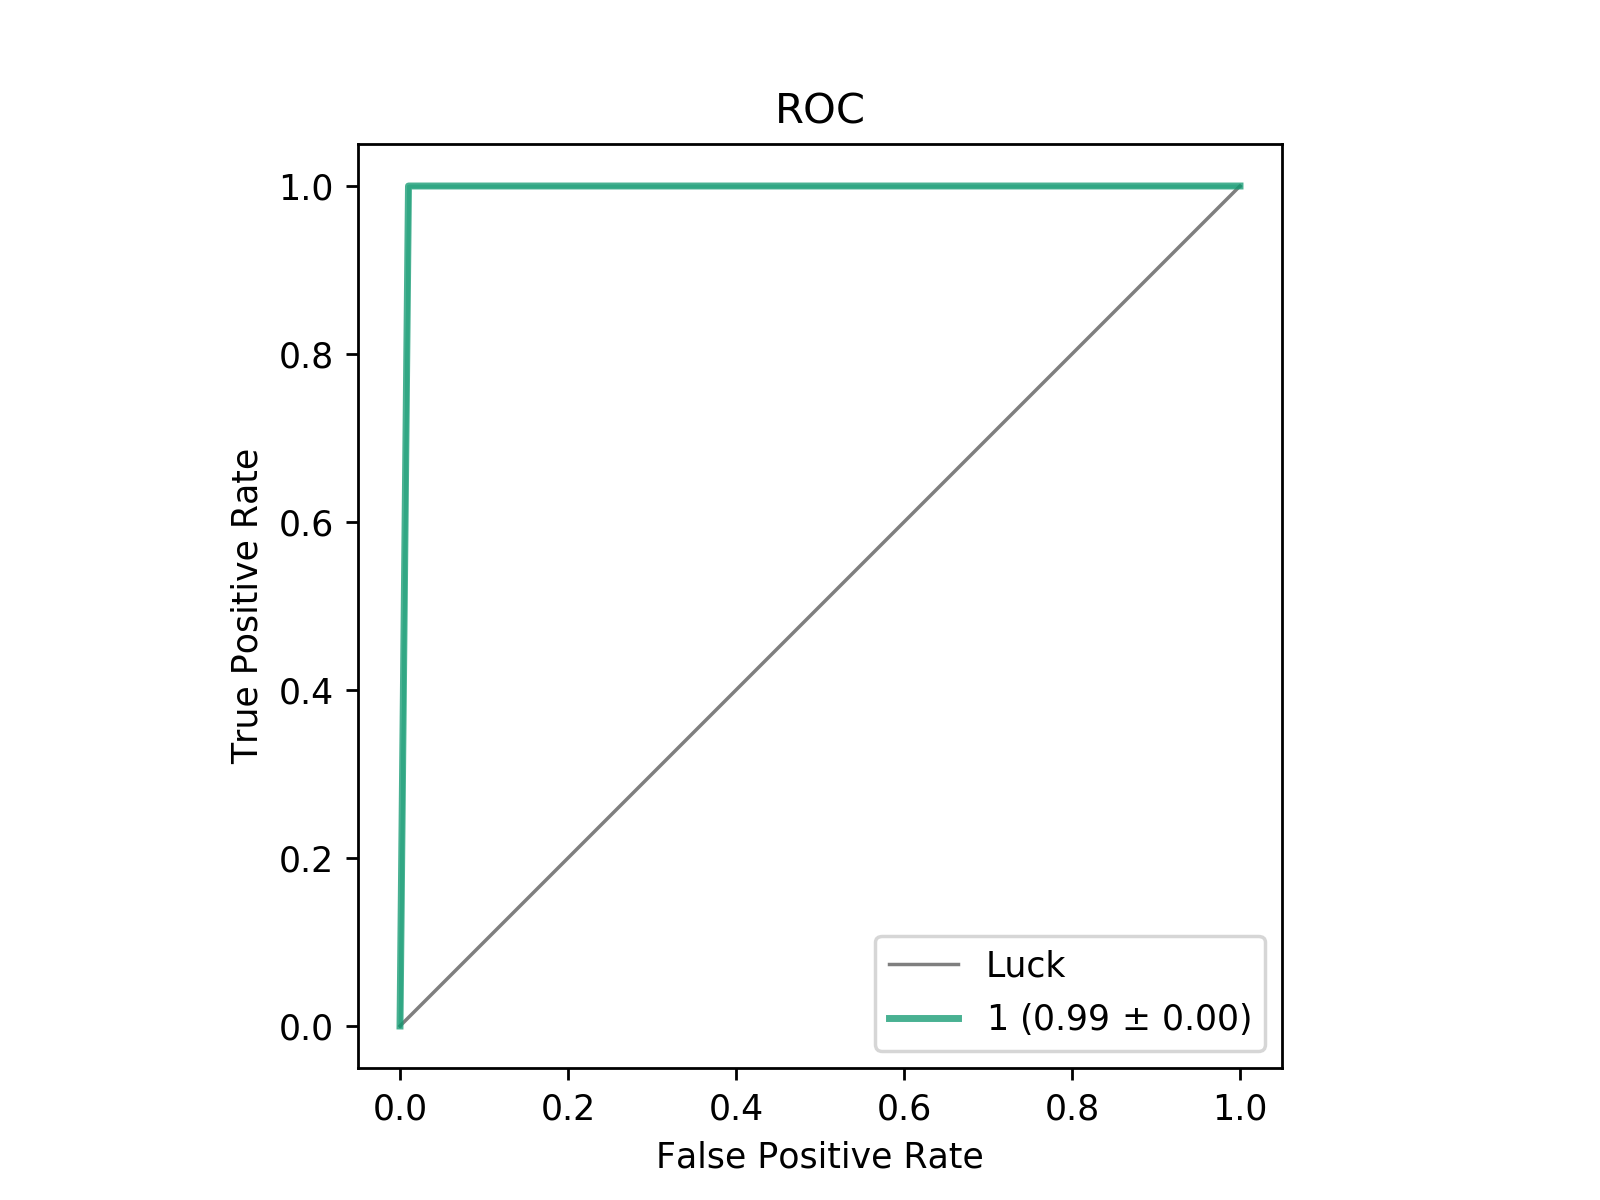

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [18]:
# plot within model cross validation ROC
training.plot_roc(res_apoe, classes=[1], cv=True)

In [19]:
# train RF classifier on all the samples from ApoE KO
clf_apoe = RandomForestClassifier(500, oob_score=True, random_state=0)
clf_apoe.fit(X_train, y_train)
clf_apoe.oob_score_

1.0

In [20]:
# retrieve ranked list of importance of features for IHH prediction
features = apoe1.feature_metadata.copy()
fimp = clf_apoe.feature_importances_
features['importance.score'] = fimp
features.sort_values(by='importance.score', ascending=False, inplace=True)
features.head(10)

,Taxon,Confidence,_feature_id,taxonomy,importance.score
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGGATGCCAAGTCAGCGGTAAAAAAGCGGTGCTCAACGCCGTCGAGCCGTTGAAACTGGCGTTCTTGAGTGGGCGAGAAGTATGCGGAATGCGTGGT,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,1.000000,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,NA,0.104809
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGTAATGTAAGTCTGATGTGAAAGCCCGGGGCTCAACCCCGGGACTGCATTGGAAACTATGTAACTAGAGTACCGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.854416,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,NA,0.095011
TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,1.000000,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,NA,0.088713
TACGTAGGTGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTGCGCAGGCGGCCGGGCAAGTCCGCAGTAAAAACTGGAGGCTCAACCTTCAGGGGCTGCGGAAACTGTCCGGCTGGAGAGCAGGAGAGGACGGTGGAACTCCATGT,k__Bacteria; p__Firmicutes; c__Erysipelotrichi...,0.987143,TACGTAGGTGGCGAGCGTTATCCGGAATGATTGGGCGTAAAGGGTG...,NA,0.079063
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGACTGTCAAGTCAGCGGTAAAATTGAGAGGCTCAACCTCTTCCCGCCGTTGAAACTGGTGGTCTTGAGTGGATGAGAAGTACGCGGAATGCGTGGT,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999998,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,NA,0.045629
TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAGCGTAGACGGCAGCGCAAGTCTGGAGTGAAATGCCGGGGCCCAACCCCGGAACTGCTTTGGAAACTGTGCAGCTCGAGTGCAGGAGAGGTAAGCGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.920555,TACGTAGGGGGCAAGCGTTATCCGGATTTACTGGGTGTAAAGGGAG...,NA,0.042020
TACGTAGGTGGCGAGCGTTATCCGGAATCATTGGGCGTAAAGAGGGAGCAGGCGGCCTGGAGGGTCTATTGTTAAAAGGCAGTGGCTTAACCATTGCAAGGCGAAGAAACCGGCAGGCTAGAGTTCTAAAGAGGATCGTGGAATTCCATG,k__Bacteria; p__Firmicutes; c__Erysipelotrichi...,0.990357,TACGTAGGTGGCGAGCGTTATCCGGAATCATTGGGCGTAAAGAGGG...,NA,0.027980
TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCGCGCAGGTGGTTAATTAAGTCTGATGTGAAAGCCCACGGCTTAACCGTGGAGGGTCATTGGAAACTGGTTGACTTGAGTGCAGAAGAGGGAAGTGGAATTCCATG,k__Bacteria; p__Firmicutes; c__Bacilli; o__Tur...,0.999976,TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGCG...,NA,0.027749
TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGTTCGTAGGCGGTTTGTTAAGTCTAAAATTAAAGCCTGGGGCTCAACCTCAGTTCGTTTTAGAAACTGGCAGACTTGAGTGTGGTAGAGGCAAGTGGAATTTCTAGT,k__Bacteria; p__Tenericutes; c__Mollicutes; o_...,1.000000,TACGTAGGGAGCAAGCGTTATCCGGATTTATTGGGCGTAAAGCGTT...,NA,0.023705
TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTGCGTAGGCTGTTTCGTAAGTCGTGTGTGAAAGGCGCGGGCTCAACCCGCGGACGGCACATGATACTGCGAGACTAGAGTAATGGAGGGGGAACCGGAATTCTCGG,k__Bacteria; p__Verrucomicrobia; c__Verrucomic...,1.000000,TACAGAGGTCTCAAGCGTTGTTCGGAATCACTGGGCGTAAAGCGTG...,NA,0.019828


In [21]:
# save feature importance table
# features.to_csv('../data/microbiome/imp.score.apoe.microbiome.csv', sep=',', index=False)

#### 1. test on ApoE KO batch 2 (IH vs. Air) as negative control

In [25]:
apoe2_IH = apoe2.filter_by_metadata(field='exposure_type', select=['Air', 'IH'])

In [26]:
# prepare testing data
X_test = apoe2_IH.data
y_test = []

for idx in apoe2_IH.sample_metadata.index:
    if apoe2_IH.sample_metadata.loc[idx, 'exposure_type'] == 'Air':
        y_test.append(0)
    if apoe2_IH.sample_metadata.loc[idx, 'exposure_type'] == 'IH':
        y_test.append(1)

In [27]:
apoe2_IH.sample_metadata.exposure_type = y_test

In [28]:
# predict IHH-exposure in Ldlr KO animals
res_apoeihc2ih = pd.DataFrame(clf_apoe.predict_proba(X_test))
res_apoeihc2ih.columns = clf_apoe.classes_
res_apoeihc2ih['Y_TRUE'] = y_test
res_apoeihc2ih['CV'] = -1

<IPython.core.display.Javascript object>


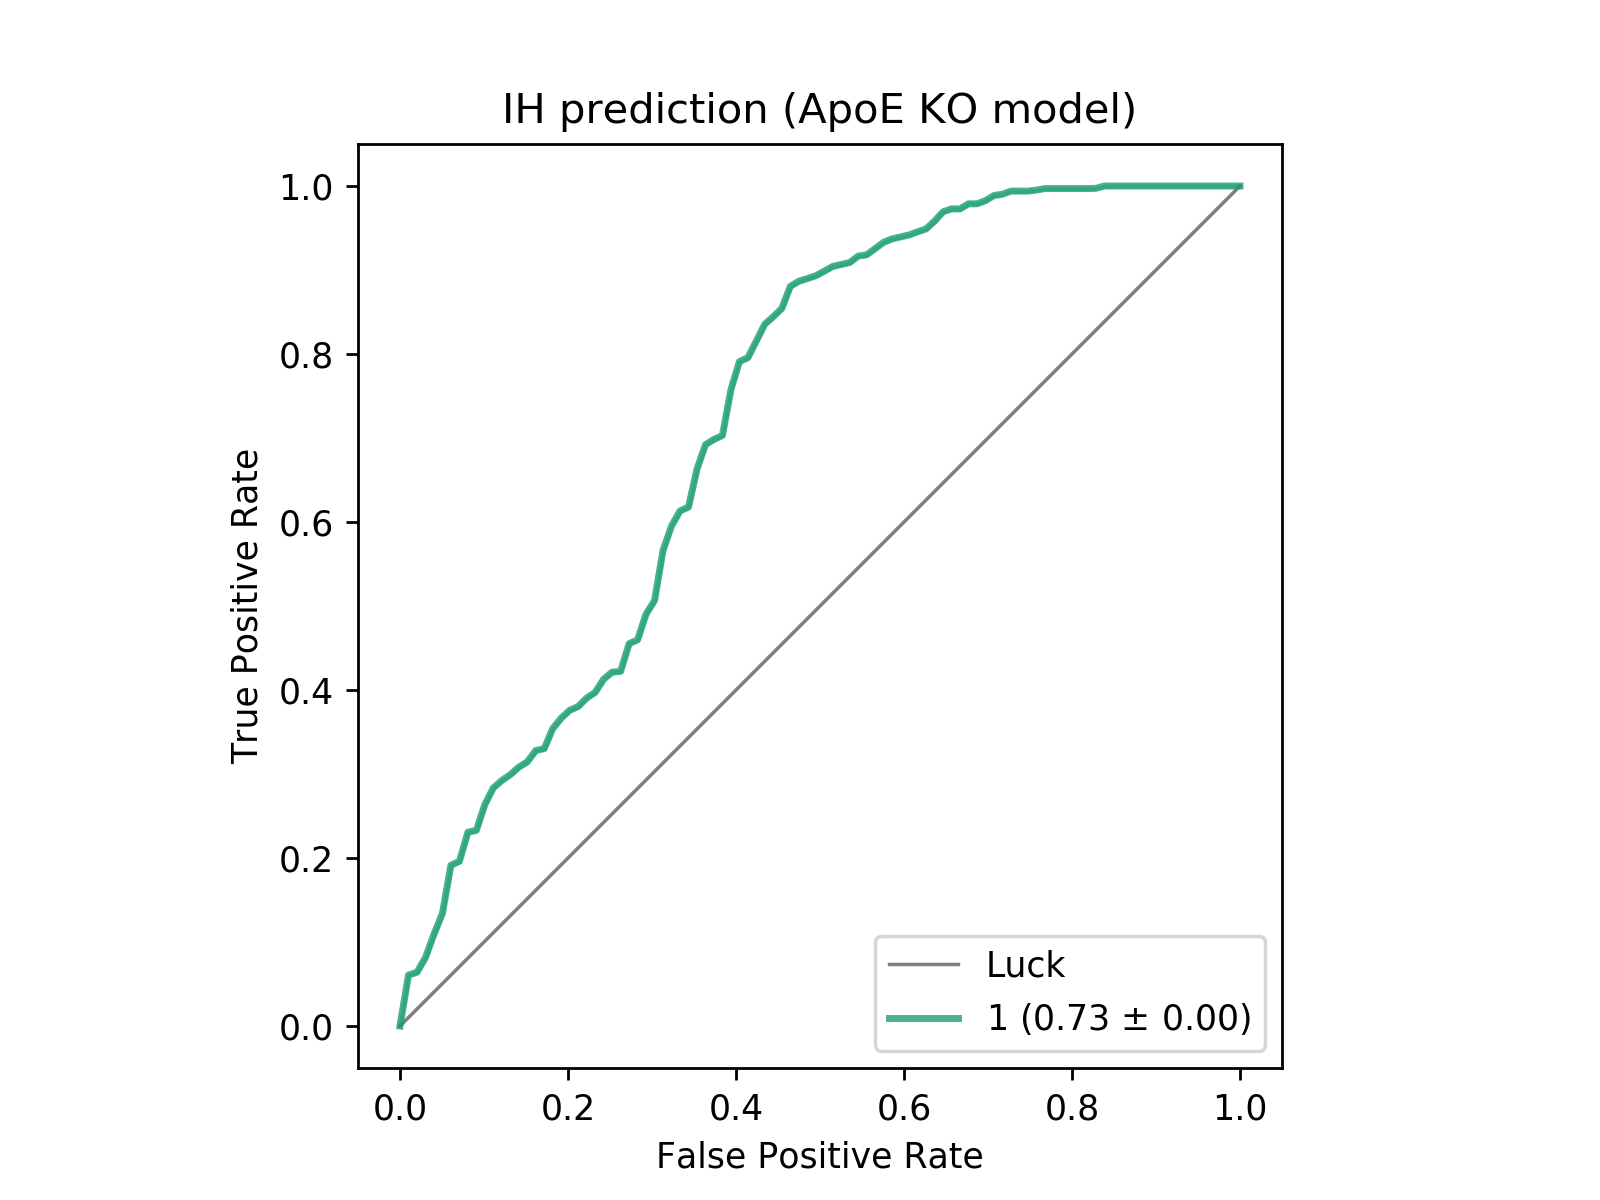

In [29]:
plot_roc(res_apoeihc2ih, classes=[1], title= 'IH prediction (ApoE KO model)')

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


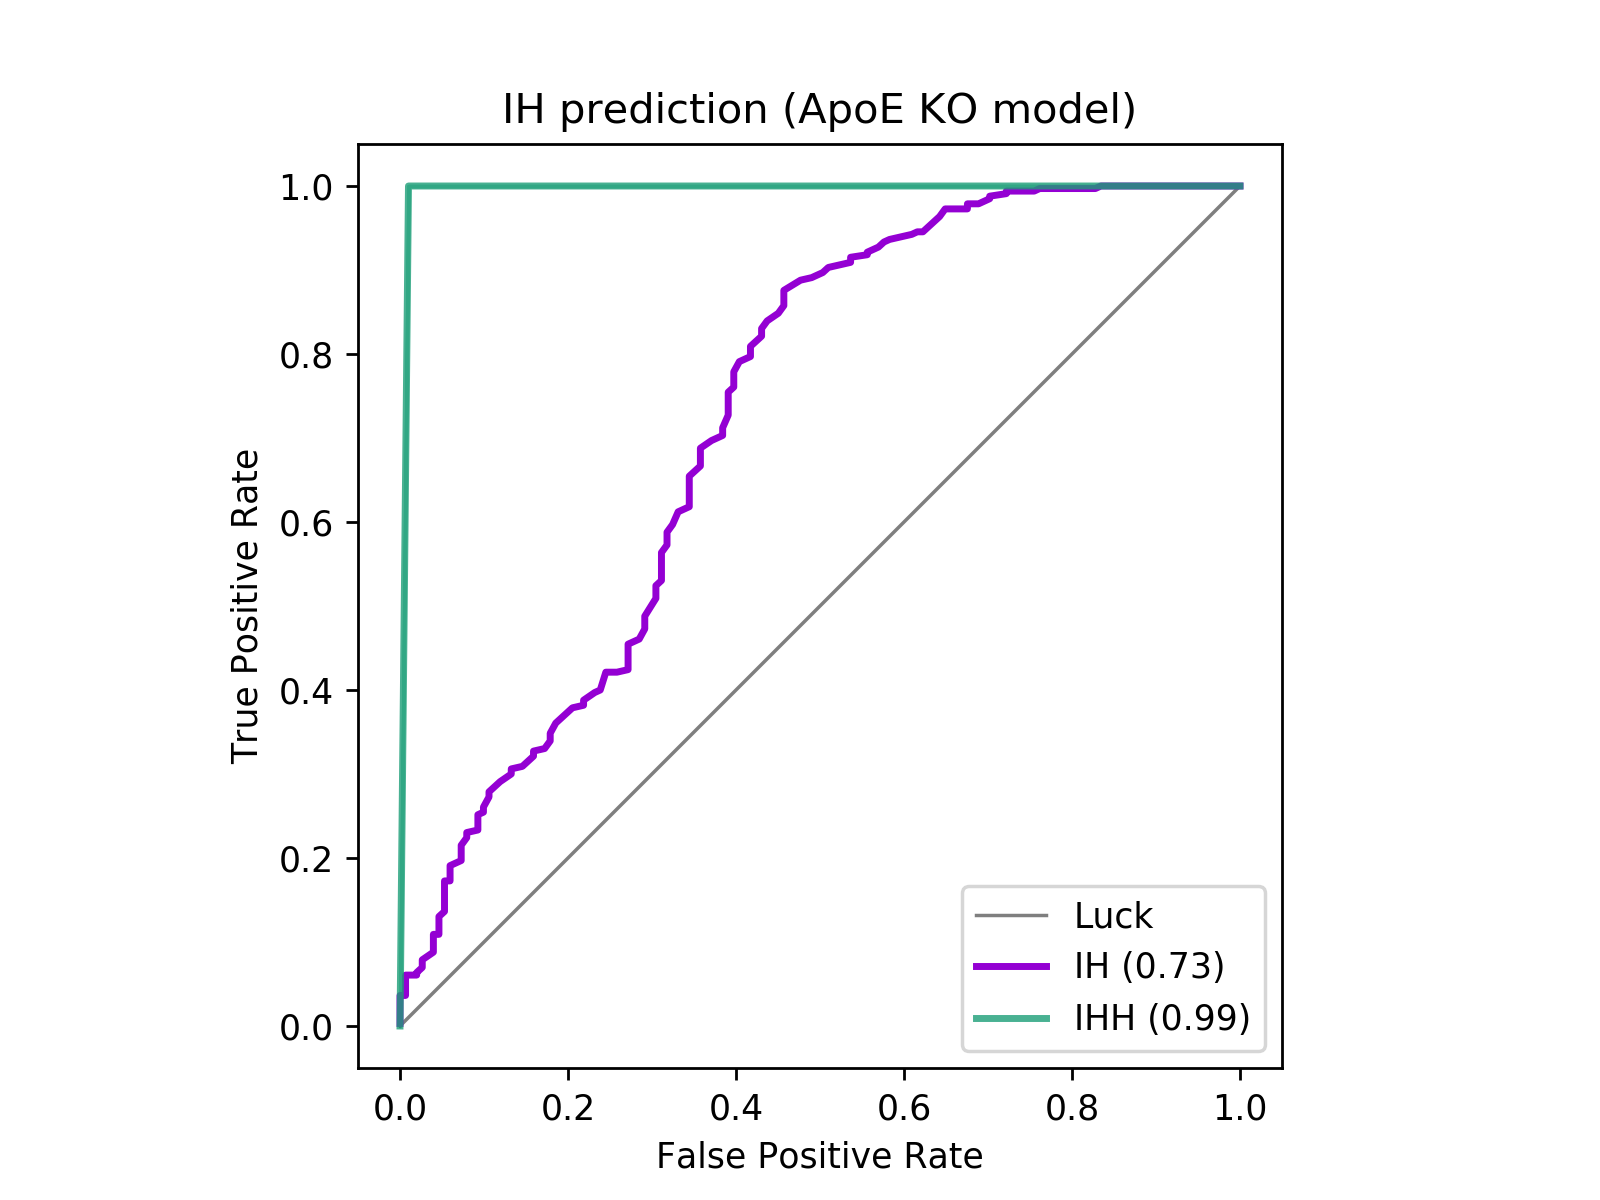

2019-03-23 09:36:50 WARNING The cross validation fold 4 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 1


/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [30]:
# plotting both ROC curves together
res_comb = pd.concat([res_apoe, res_apoeihc2ih])
fig = plot_roc_mod(res_comb, cmodel='darkviolet', classes=[1], 
                   title= 'IH prediction (ApoE KO model)', 
                   cv_name='IHH', test_name='IH').get_figure()
fig.savefig('../figures/auc_ApoEKOmodel_16S_IH.pdf', bbox_to_inches='tight')

#### 2. test on ApoE KO batch 2 (IC vs. Air) as negative control

In [31]:
apoe2_IC = apoe2.filter_by_metadata(field='exposure_type', select=['Air', 'IC'])

In [32]:
# prepare testing data
X_test = apoe2_IC.data
y_test = []

for idx in apoe2_IC.sample_metadata.index:
    if apoe2_IC.sample_metadata.loc[idx, 'exposure_type'] == 'Air':
        y_test.append(0)
    if apoe2_IC.sample_metadata.loc[idx, 'exposure_type'] == 'IC':
        y_test.append(1)

In [33]:
apoe2_IC.sample_metadata.exposure_type = y_test

In [34]:
# predict IHH-exposure in Ldlr KO animals
res_apoeihc2ic = pd.DataFrame(clf_apoe.predict_proba(X_test))
res_apoeihc2ic.columns = clf_apoe.classes_
res_apoeihc2ic['Y_TRUE'] = y_test
res_apoeihc2ic['CV'] = -1

<IPython.core.display.Javascript object>


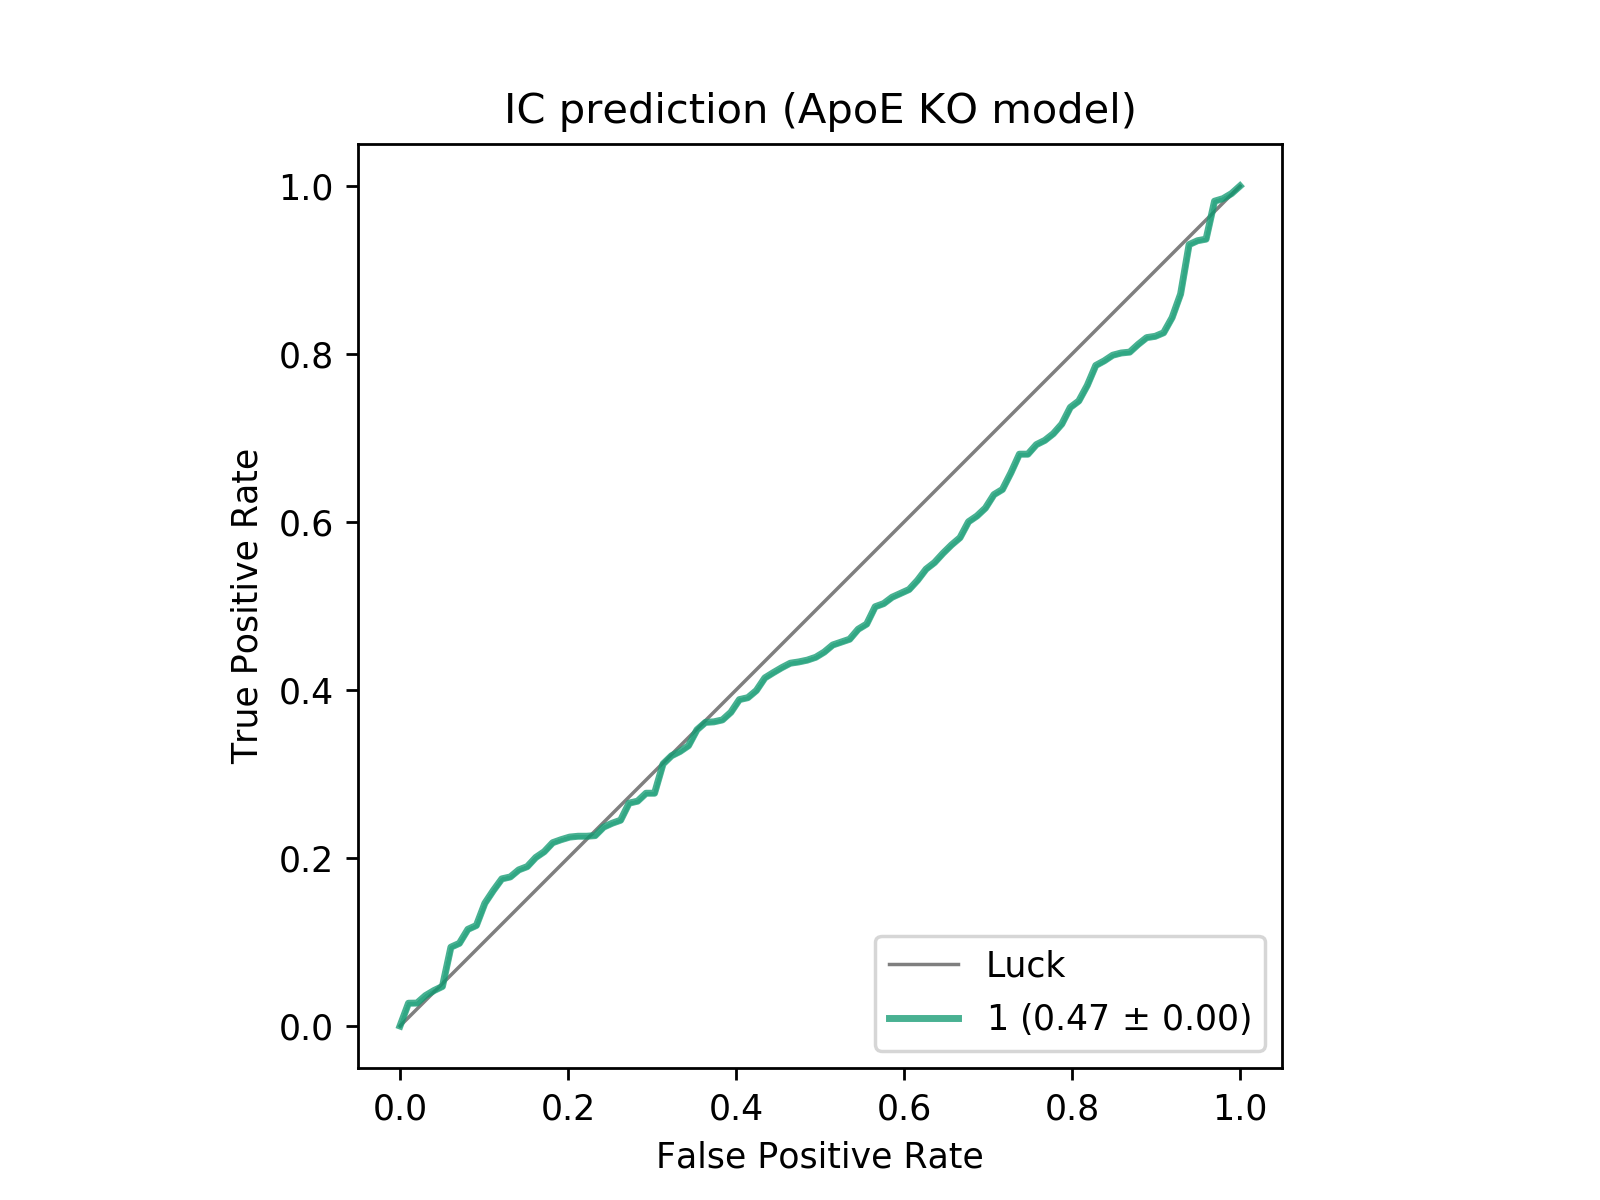

In [35]:
plot_roc(res_apoeihc2ic, classes=[1], title= 'IC prediction (ApoE KO model)')

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


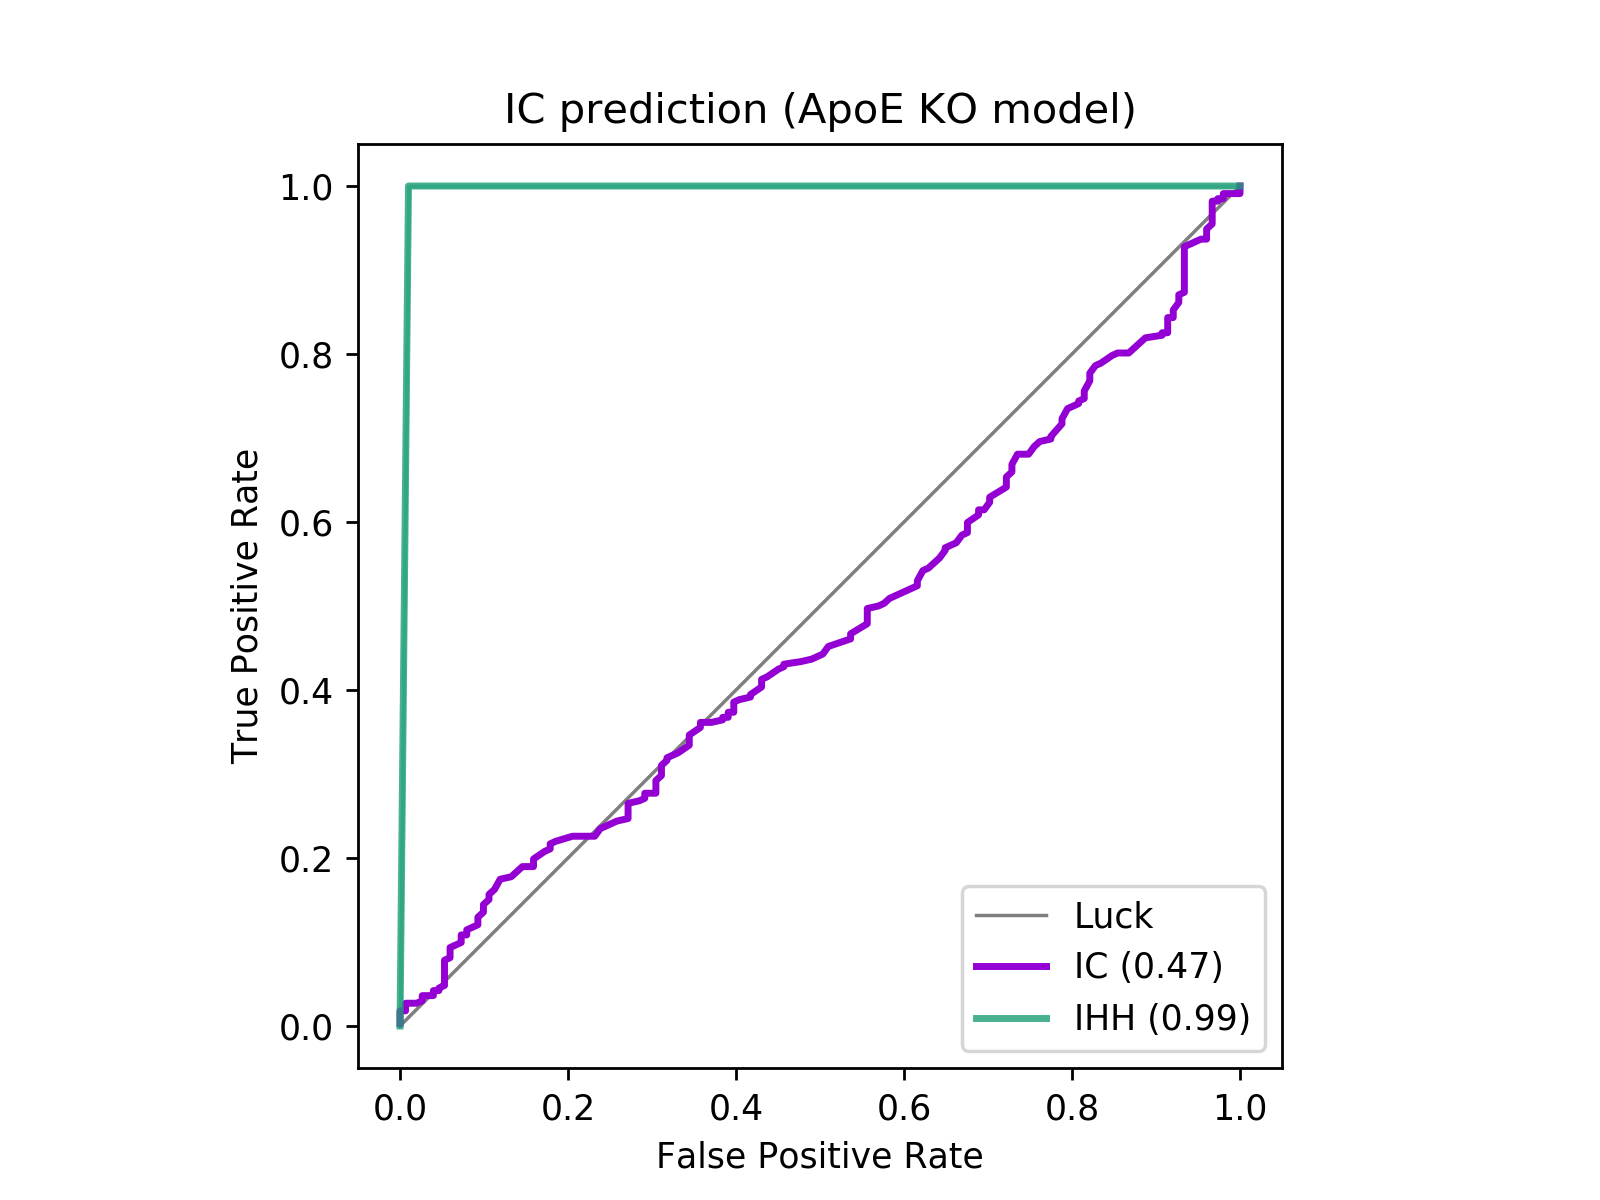

2019-03-23 09:38:03 WARNING The cross validation fold 4 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 1


/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [37]:
# plotting both ROC curves together
res_comb = pd.concat([res_apoe, res_apoeihc2ic])
fig = plot_roc_mod(res_comb, cmodel='darkviolet', classes=[1],
                   title= 'IC prediction (ApoE KO model)', 
                   cv_name='IHH', test_name='IC').get_figure()
fig.savefig('../figures/auc_ApoEKOmodel_16S_IC.pdf', bbox_to_inches='tight')

### Train on Ldlr KO & test on ApoE KO batch 2 (negative control)

#### Train on Ldlr KO batch 1 (Air vs IHH) 

Below, we make a Random Forest (RF) model using microbiome data from ApoE KO animals. We use 5-fold cross-validation (CV) and ensure that samples belonging to the same mouse (denoted by 'mouse_number') are either in training or testing set for each train/test split. We used GroupKfold (http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupKFold.html) for this.

In [38]:
ldlr.sample_metadata.exposure_type.value_counts()

Air    85
IHH    85
Name: exposure_type, dtype: int64

In [39]:
# prepare training data
X_train = ldlr.data

# label encoder
y_train = []
for idx in ldlr.sample_metadata.index:
    if ldlr.sample_metadata.loc[idx, 'exposure_type'] == 'IHH':
        y_train.append(1)
    else:
        y_train.append(0)

In [40]:
ldlr.sample_metadata.exposure_type = y_train

In [41]:
it_ldlr = ldlr.classify('exposure_type',
                          RandomForestClassifier(n_estimators=500),
                          GroupKFold(5).split(
                          X_train, y_train, 
                          ldlr.sample_metadata['mouse_number']))

In [42]:
# predictions for each CV fold
res_ldlr = next(it_ldlr)
res_ldlr.head()

,0,1,Y_TRUE,SAMPLE,CV
0,0.112,0.888,1,10422.17.F.10,0
1,0.106,0.894,1,10422.17.F.11,0
2,0.114,0.886,1,10422.17.F.12,0
3,0.138,0.862,1,10422.17.F.13,0
4,0.246,0.754,1,10422.17.F.3,0


<IPython.core.display.Javascript object>


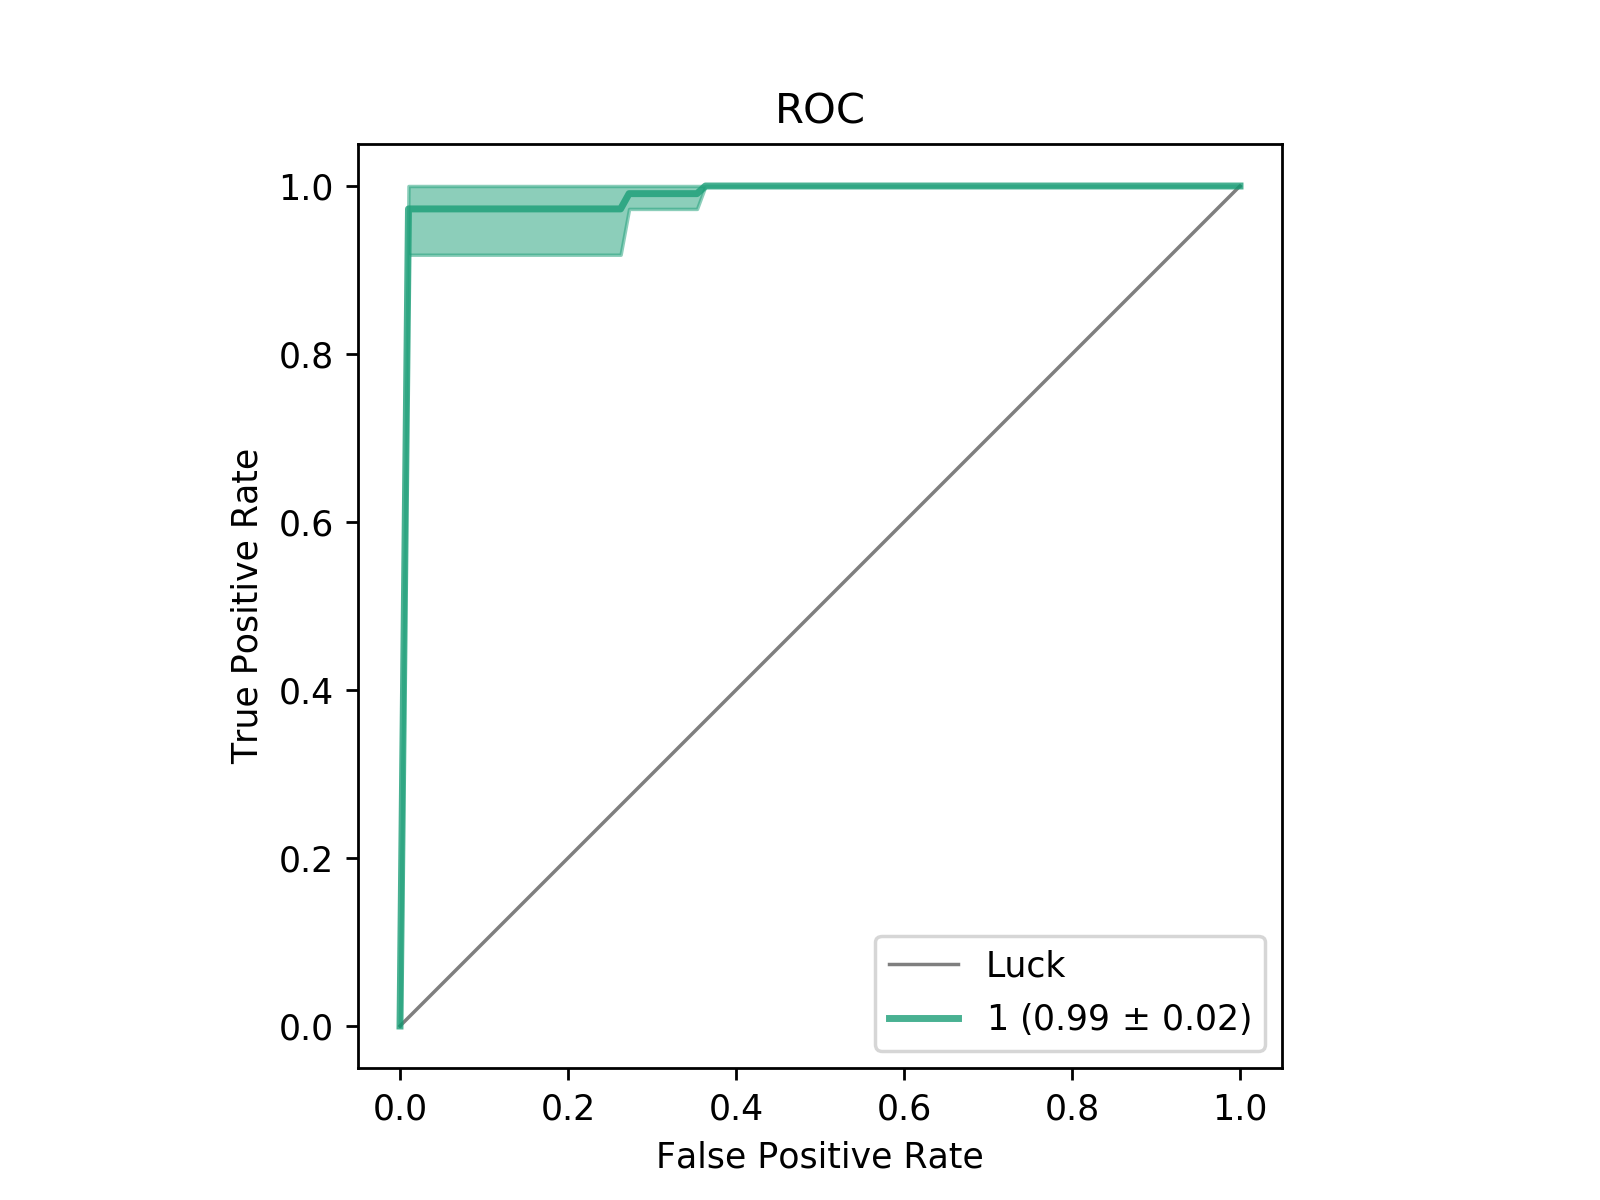

In [43]:
# plot within model cross validation ROC
training.plot_roc(res_ldlr, classes=[1], cv=True)

In [44]:
# train RF classifier on all the samples from ApoE KO
clf_ldlr = RandomForestClassifier(500, oob_score=True, random_state=0)
clf_ldlr.fit(X_train, y_train)
clf_ldlr.oob_score_

0.95294117647058818

In [45]:
# retrieve ranked list of importance of features for IHH prediction
features = ldlr.feature_metadata.copy()
fimp = clf_ldlr.feature_importances_
features['importance.score'] = fimp
features.sort_values(by='importance.score', ascending=False, inplace=True)
features.head(10)

,Taxon,Confidence,_feature_id,taxonomy,importance.score
TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,1.000000,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,NA,0.075626
TACGTAGGGGGCGAGCGTTATCCGGATTCATTGGGCGTAAAGCGCGCGTAGGCGGCCAGTTAGGTCGGGAGTCAAATTTCGGGGCTCAACCCCGTCTCGCTCCCGATACCGGCTGGCTTGAGTGTGGTAGGGGAAGGCGGAATTCCCGGT,k__Bacteria; p__Actinobacteria; c__Coriobacter...,0.853446,TACGTAGGGGGCGAGCGTTATCCGGATTCATTGGGCGTAAAGCGCG...,NA,0.059481
TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGACTTTTAAGTGAGATGTGAAATACTCGGGCTCAACTTGAGTGCTGCATTTCAAACTGGAAGTCTAGAGTGCAGGAGAGGAGAATGGAATTCTTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,1.000000,TACGTAGGTGGCGAGCGTTGTCCGGATTTACTGGGCGTAAAGGGAG...,NA,0.049957
TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCGTGTAGCCGGGCTGACAAGTCAGATGTGAAATCCGGGGGCTCAACCCCCGAACTGCATTTGAAACTGTTGGTCTTGAGTATCGGAGAGGCAGGCGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.818176,TACGTAGGTGGCAAGCGTTGTCCGGATTTACTGGGTGTAAAGGGCG...,NA,0.034543
TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGGGAGCAGGCGGCAGCAAAGGTCTGTGGTGAAAGACTGAAGCTTAACTTCAGTAAGCCATAGAAACCGGGCAGCTAGAGTGCAGGAGAGGATCGTGGAATTCCATGT,k__Bacteria; p__Firmicutes; c__Erysipelotrichi...,0.981888,TACGTAGGTGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGGG...,NA,0.033621
TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTGCGTAGGCGGATTTTTAAGTCAGCGGTAAAATGTCCGGGCTCAACCCGGGCCGGCCGTTGAAACTGGGGATCTTGAGTGGGCGAGAAGTATGCGGAATGCGTGGT,k__Bacteria; p__Bacteroidetes; c__Bacteroidia;...,0.999991,TACGGAGGATGCGAGCGTTATCCGGATTTATTGGGTTTAAAGGGTG...,NA,0.032882
TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGCGTGTAGGCGGGAATGCAAGTCAGATGTGAAAACTCAGGGCTCAACCCTGAGCCTGCATTTGAAACTGTATTTCTTGAGTGCTGGAGAGGCAATCGGAATTCCGTG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.999922,TACGTAGGTGGCAAGCGTTATCCGGATTTATTGGGTGTAAAGGGCG...,NA,0.024400
TACGTAGGGGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGTACGTAGGTGGCAACCTAAGCGCAGGGTTTAAGGCAATGGCTCAACCATTGTTCGCCCTGCGAACTGGGATGCTTGAGTGCAGGAGAGGAAAGCGGAATTCCTAGT,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.999996,TACGTAGGGGGCAAGCGTTATCCGGAATTATTGGGCGTAAAGAGTA...,NA,0.023375
TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGCGTAAAGGGAGCGTAGGCGGCCTGCCAAGTCTGATGTGAAATACCGGGGCTCAACCCCGGGGCTGCATTGGAAACTGGCAGGCTGGAGTGCCGGAGAGGCAGGCGGAATTCCTAG,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.768268,TACGTATGGAGCAAGCGTTATCCGGATTTACTGGGCGTAAAGGGAG...,NA,0.022649
TACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAGCGTAGGCGGGCGAGAAAGTTGAATGTTAAATCTACCGGCTTAACTGGTAGCTGCGTTCAAAACTTCTTGTCTTGAGTGAAGTAGAGGCAGGCGGAATTCCTAGT,k__Bacteria; p__Firmicutes; c__Clostridia; o__...,0.974766,TACGTAGGGAGCGAGCGTTGTCCGGAATTACTGGGTGTAAAGGGAG...,NA,0.021580


In [46]:
# save feature importance table
# features.to_csv('../data/microbiome/imp.score.apoe.microbiome.csv', sep=',', index=False)

#### 1B. test on ApoE KO batch 2 (IH vs. Air) as negative control

In [47]:
apoe2_IH = apoe2.filter_by_metadata(field='exposure_type', select=['Air', 'IH'])

In [48]:
# prepare testing data
X_test = apoe2_IH.data
y_test = []

for idx in apoe2_IH.sample_metadata.index:
    if apoe2_IH.sample_metadata.loc[idx, 'exposure_type'] == 'Air':
        y_test.append(0)
    if apoe2_IH.sample_metadata.loc[idx, 'exposure_type'] == 'IH':
        y_test.append(1)

In [49]:
apoe2_IH.sample_metadata.exposure_type = y_test

In [50]:
# predict IHH-exposure in Ldlr KO animals
res_ldlrihc2ih = pd.DataFrame(clf_ldlr.predict_proba(X_test))
res_ldlrihc2ih.columns = clf_ldlr.classes_
res_ldlrihc2ih['Y_TRUE'] = y_test
res_ldlrihc2ih['CV'] = -1

<IPython.core.display.Javascript object>


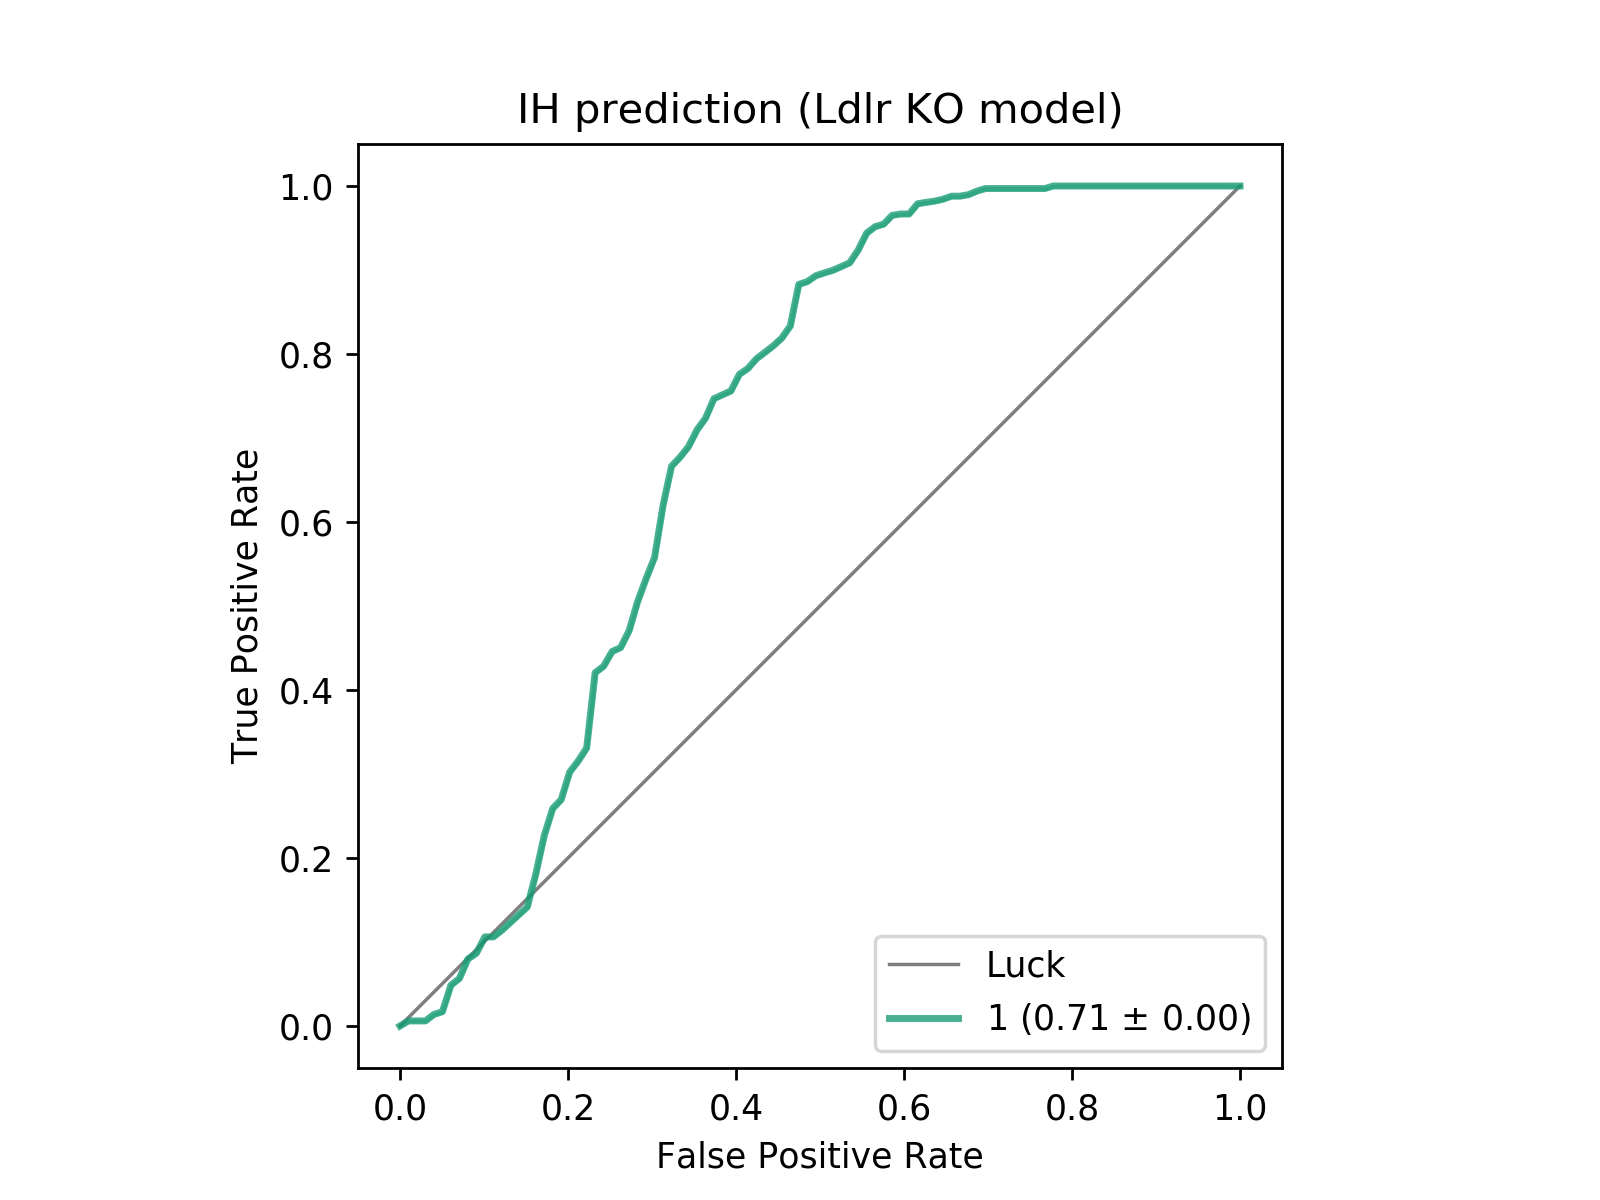

In [51]:
plot_roc(res_ldlrihc2ih, classes=[1], title='IH prediction (Ldlr KO model)')

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


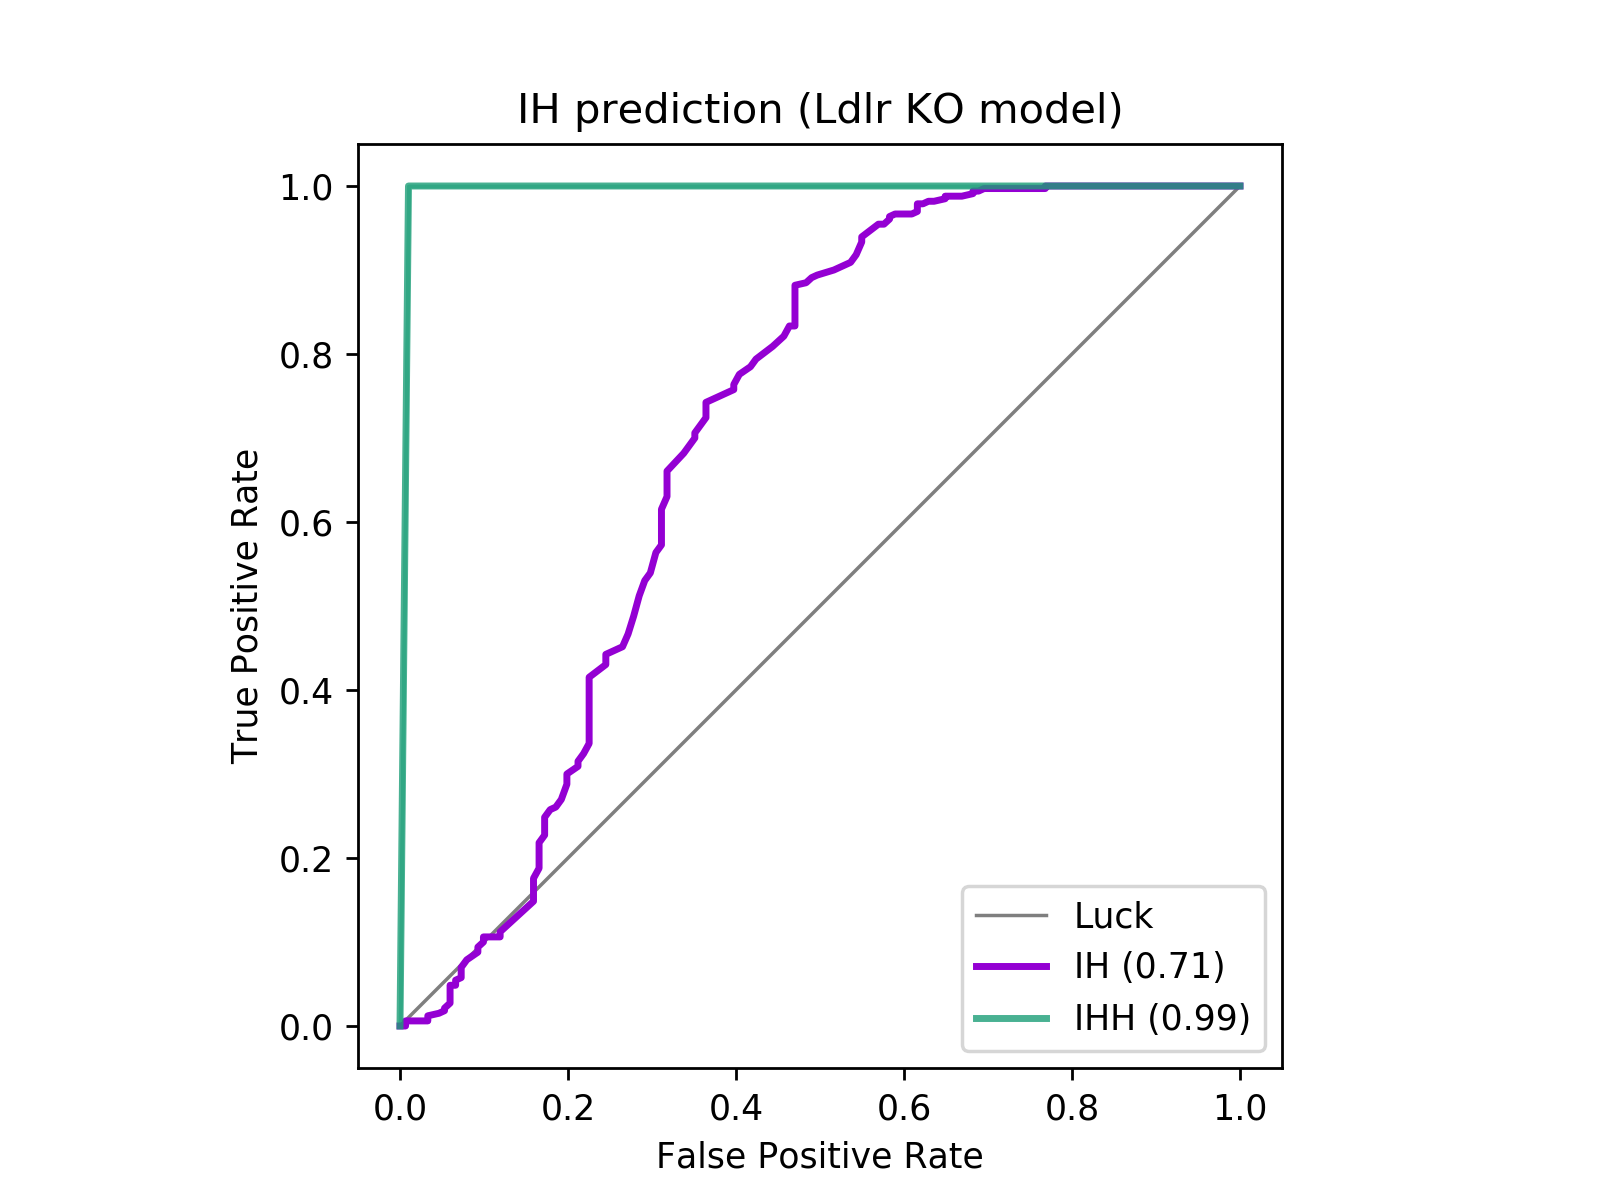

2019-03-23 09:40:48 WARNING The cross validation fold 4 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 1


/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [52]:
# plotting both ROC curves together
res_comb = pd.concat([res_apoe, res_ldlrihc2ih])
fig = plot_roc_mod(res_comb, cmodel='darkviolet', classes=[1],
                  title= 'IH prediction (Ldlr KO model)', 
                  cv_name='IHH', test_name='IH').get_figure()
fig.savefig('../figures/auc_LdlrKOmodel_16S_IH.pdf', bbox_to_inches='tight')

#### 2. test on ApoE KO batch 2 (IC vs. Air) as negative control

In [53]:
apoe2_IC = apoe2.filter_by_metadata(field='exposure_type', select=['Air', 'IC'])

In [54]:
# prepare testing data
X_test = apoe2_IC.data
y_test = []

for idx in apoe2_IC.sample_metadata.index:
    if apoe2_IC.sample_metadata.loc[idx, 'exposure_type'] == 'Air':
        y_test.append(0)
    if apoe2_IC.sample_metadata.loc[idx, 'exposure_type'] == 'IC':
        y_test.append(1)

In [55]:
apoe2_IC.sample_metadata.exposure_type = y_test

In [56]:
# predict IHH-exposure in Ldlr KO animals
res_ldlrihc2ic = pd.DataFrame(clf_ldlr.predict_proba(X_test))
res_ldlrihc2ic.columns = clf_ldlr.classes_
res_ldlrihc2ic['Y_TRUE'] = y_test
res_ldlrihc2ic['CV'] = -1

<IPython.core.display.Javascript object>


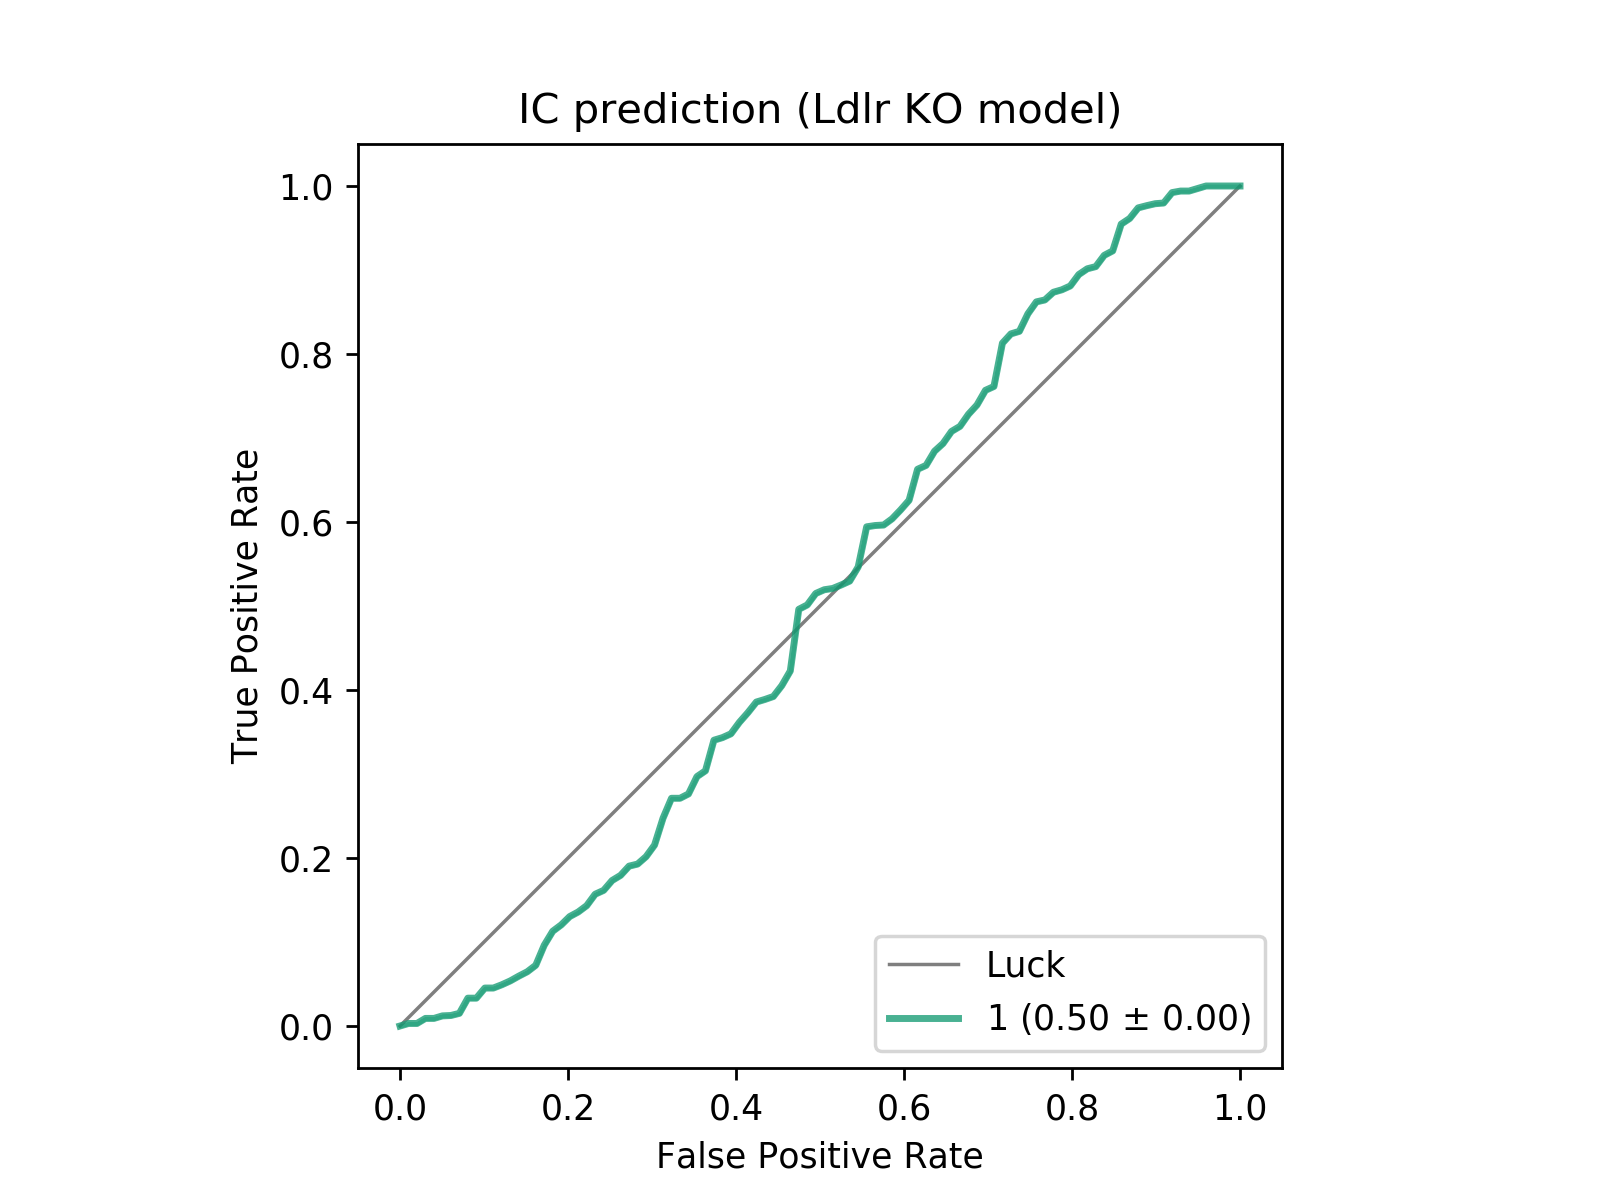

In [57]:
plot_roc(res_ldlrihc2ic, classes=[1], title='IC prediction (Ldlr KO model)')

/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


<IPython.core.display.Javascript object>


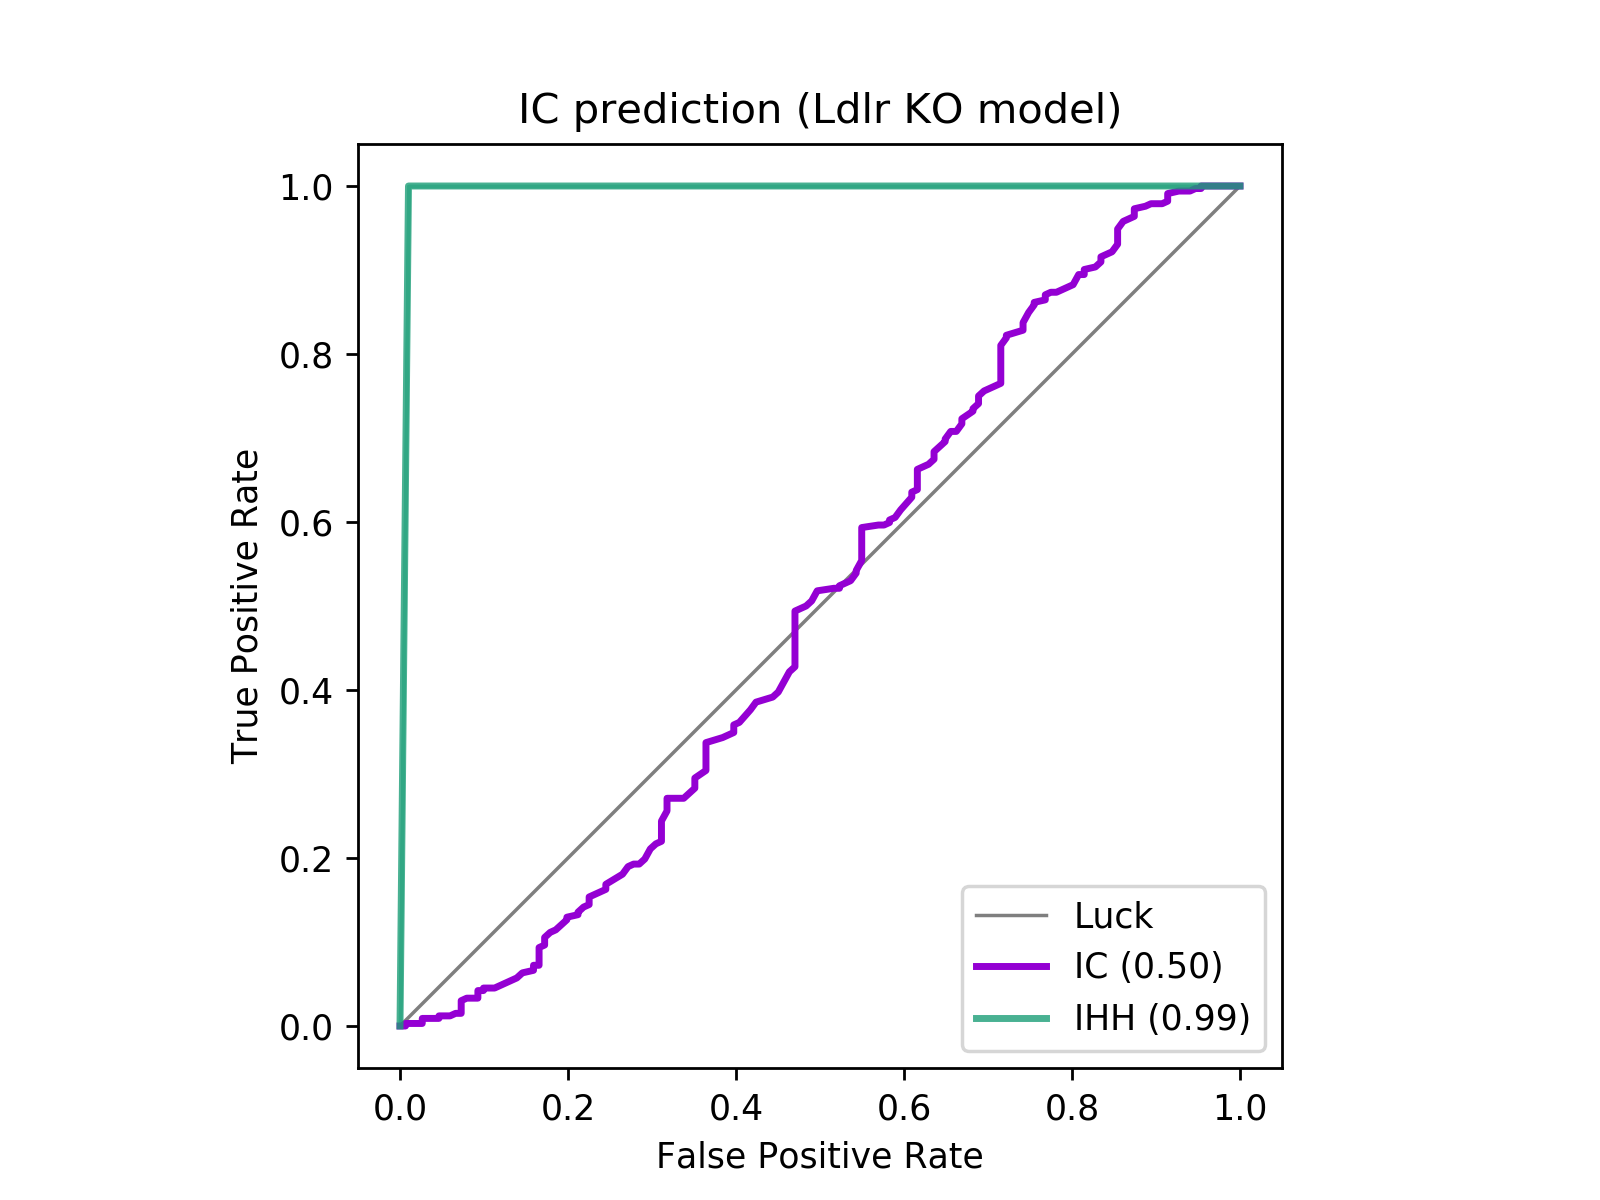

2019-03-23 09:42:03 WARNING The cross validation fold 4 is skipped because the true positive rate or false positive rate computation failed. This is likely because you have either no true positive or no negative samples in this cross validation for the class 1


/Users/priya/miniconda3/envs/calour/lib/python3.5/site-packages/sklearn/metrics/ranking.py:563: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  UndefinedMetricWarning)


In [58]:
# plotting both ROC curves together
res_comb = pd.concat([res_apoe, res_ldlrihc2ic])
fig = plot_roc_mod(res_comb, cmodel='darkviolet', classes=[1],
                  title= 'IC prediction (Ldlr KO model)', 
                  cv_name='IHH', test_name='IC').get_figure()
fig.savefig('../figures/auc_LdlrKOmodel_16S_IC.pdf', bbox_to_inches='tight')